## LoadDataset

In [1]:
from parallel import ParallelExecutor, TaskSpec
import torch
from utils import prepare_dataset
%load_ext autoreload
%autoreload 2

之前做了一个实验来判断如果让各weight更orthogonal一点，会不会影响aggregation的结果。
在keras里面只需要使用

```python
tf.keras.regularizers.OrthogonalRegularizer
```

在Pytorch里需要重写trainer 或者 重写一个loss function

##  Trainer

In [2]:
from trainer import DefaultTrainer

class TrainerWithOrthogonalRegularization(DefaultTrainer):
    def __init__(self, factor, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.factor = factor

    def train_step(self, batch):
        self.step += 1
        self.optimizer.zero_grad()
        inputs, targets = batch
        inputs, targets = inputs.to(self.device), targets.to(self.device)
        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        reg_loss = self._orthogonal_regularization_loss()
        total_loss = loss + self.factor * reg_loss
        # the same in DefaultTrainer
        total_loss.backward()
        self.optimizer.step()
        metrics = self.metrics(outputs, targets)
        metrics['loss'] = loss.item()
        metrics['reg_loss'] = reg_loss.item()
        return metrics
        
    
    def _orthogonal_regularization_loss(self) -> torch.Tensor:
        self.linear_layers = [module for module in self.model.modules() if isinstance(module, torch.nn.Linear)]
        ortho_loss = 0.0
        for layer in self.linear_layers:
            weight = layer.weight
            identity = torch.eye(weight.shape[1], device=weight.device)
            ortho_loss += torch.norm(weight.t() @ weight - identity, p='fro')
        return ortho_loss
             
        
    def configure_optimizers(self):
        optimizer = super().configure_optimizers()
        if self.orthogonal_regularization > 0.0:
            optimizer.param_groups[0]['weight_decay'] = 0.0
        return optimizer

In [3]:
from lightning import seed_everything
from utils import prepare_dataset, build_mlp_model
import torchmetrics
import logger
def reg_factor_experiment(factor):
    seed_everything(42)
    # same initialization
    trainset, _ = prepare_dataset("MNIST", "MLP")
    model = build_mlp_model()
    metrics = torchmetrics.MetricCollection(
        [torchmetrics.Accuracy(task='multiclass', num_classes=10),]
    )
    loggers = logger.LoggerCollection(
        [logger.CSVLogger(name=f"factor_{factor}", 
                             saving_dir="different_reg_factors")]
    )
    criterion = torch.nn.CrossEntropyLoss()
    trainer = TrainerWithOrthogonalRegularization(
        factor=factor,
        model=model,
        optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
        criterion=criterion,
        metrics=metrics,
        loggers=loggers,
        device="cuda",
        need_saving=True,
        saving_on='last',
        saving_dir="different_reg_factors/checkpoints",
        saving_name=f"factor_{factor}",
    )
    train_loader = torch.utils.data.DataLoader(trainset, 
                                               batch_size=256, 
                                               shuffle=True)
    results = trainer.fit(train_loader, epochs=30)
    del model
    del trainer
    torch.cuda.empty_cache()
    return results

In [218]:
from parallel import SpecGenerator, TaskSpec

class FactorsSpecGenerator(SpecGenerator):
    def __iter__(self):
        self.factors = [0.0, 1e-4, 1e-3, 1e-2, 1e-1]
        for factor in self.factors:
            yield TaskSpec(
                id=f"factor_{factor}",
                args=(factor,),
                kwargs={},
            )
            
    def __next__(self) -> TaskSpec:
        return next(self.__iter__())

In [219]:
task_spec_generator = FactorsSpecGenerator()
for task_spec in task_spec_generator:
    print(task_spec)

TaskSpec(id='factor_0.0', args=(0.0,), kwargs={})
TaskSpec(id='factor_0.0001', args=(0.0001,), kwargs={})
TaskSpec(id='factor_0.001', args=(0.001,), kwargs={})
TaskSpec(id='factor_0.01', args=(0.01,), kwargs={})
TaskSpec(id='factor_0.1', args=(0.1,), kwargs={})


In [2]:
import ray
ray.shutdown()

In [220]:
executor = ParallelExecutor(gpu_fraction=0.3)
executor.run(func=reg_factor_experiment, spec_generator=task_spec_generator)

(reg_factor_experiment pid=2024105) File different_reg_factors/factor_0.001.csv already exists. It will be overwritten.


(reg_factor_experiment pid=2024105) Global seed set to 42
Epoch 0 - loss: 2.2479:   1%|          | 2/235 [00:01<01:59,  1.96it/s]
(reg_factor_experiment pid=2024107) Global seed set to 42 [repeated 4x across cluster]
Epoch 29 - loss: 0.0093: 100%|██████████| 235/235 [00:33<00:00,  6.93it/s]


(reg_factor_experiment pid=2024105) Training Ends
(reg_factor_experiment pid=2024107) File different_reg_factors/factor_0.1.csv already exists. It will be overwritten. [repeated 4x across cluster]
(reg_factor_experiment pid=2024103) Training Results: {'MulticlassAccuracy': tensor(0.9902, device='cuda:0'), 'loss': 0.029102833517529864}


Epoch 29 - loss: 0.0906:  85%|████████▌ | 200/235 [00:29<00:05,  6.83it/s] [repeated 94x across cluster]


(reg_factor_experiment pid=2024104) Training Ends [repeated 2x across cluster]
(reg_factor_experiment pid=2024104) Training Results: {'MulticlassAccuracy': tensor(0.9895, device='cuda:0'), 'loss': 0.03121933072131682} [repeated 2x across cluster]


Epoch 29 - loss: 0.0431:  97%|█████████▋| 227/235 [00:33<00:01,  6.86it/s] [repeated 50x across cluster]


Finished running tasks


[TaskResults(id='factor_0.0', results={'step': 7050, 'train_step_reg_loss': 125.1764144897461, 'train_step_loss': 0.0173956155776977, 'train_step_MulticlassAccuracy': 0.99609375, 'train_epoch_loss': 0.0291028335175298, 'train_epoch_MulticlassAccuracy': 0.9902166724205016}),
 TaskResults(id='factor_0.0001', results={'step': 7050, 'train_step_loss': 0.0131092201918363, 'train_step_MulticlassAccuracy': 0.99609375, 'train_step_reg_loss': 106.46355438232422, 'train_epoch_loss': 0.0312193307213168, 'train_epoch_MulticlassAccuracy': 0.98948335647583}),
 TaskResults(id='factor_0.001', results={'step': 7050, 'train_step_reg_loss': 61.904823303222656, 'train_step_MulticlassAccuracy': 0.9921875, 'train_step_loss': 0.0235855933278799, 'train_epoch_MulticlassAccuracy': 0.9888499975204468, 'train_epoch_loss': 0.0366222638735904}),
 TaskResults(id='factor_0.01', results={'step': 7050, 'train_step_reg_loss': 40.18989562988281, 'train_step_loss': 0.0691303089261055, 'train_step_MulticlassAccuracy': 0.9

In [221]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ckpt_paths = os.listdir("different_reg_factors/checkpoints")
dfs = []
for ckpt_path in ckpt_paths:
    name = ckpt_path.split("_")[1]
    ckpt = torch.load(os.path.join("different_reg_factors/checkpoints", ckpt_path))
    csv_path = ckpt['csv_log_path']
    df = pd.read_csv(csv_path)
    df['factor'] = name
    dfs.append(df)
df = pd.concat(dfs)

In [222]:
df.columns

Index(['step', 'train_step_loss', 'train_step_MulticlassAccuracy',
       'train_step_reg_loss', 'train_epoch_loss',
       'train_epoch_MulticlassAccuracy', 'factor'],
      dtype='object')

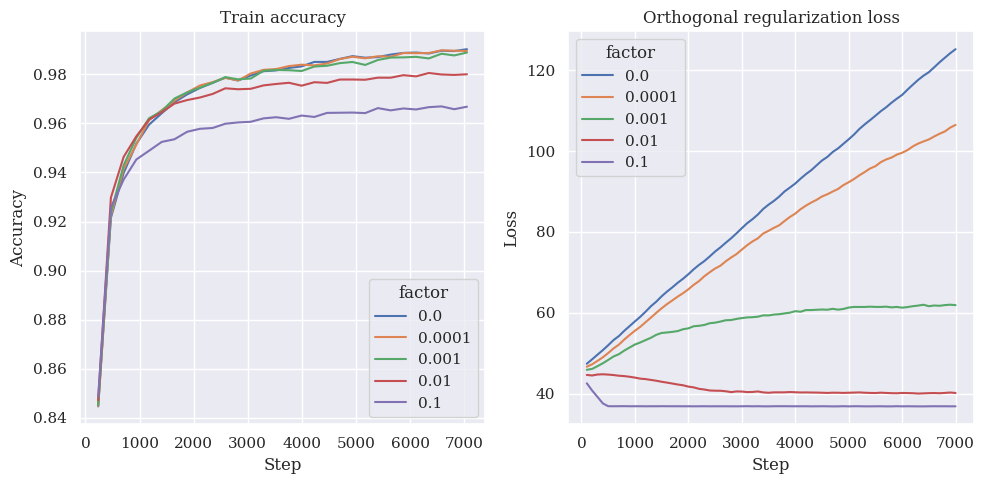

In [227]:
df_reset = df.reset_index()
df_reset.sort_values(by='factor', ascending=True, inplace=True)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
from utils import prepare_sns
prepare_sns()
sns.lineplot(data=df_reset, x='step', 
             y='train_epoch_MulticlassAccuracy', 
             hue='factor', ax=axs[0])
axs[0].set_title("Train accuracy")
axs[0].set_xlabel("Step")
axs[0].set_ylabel("Accuracy")
sns.lineplot(data=df_reset, x='step', 
             y='train_step_reg_loss', 
             hue='factor', ax=axs[1])
axs[1].set_title("Orthogonal regularization loss")
axs[1].set_xlabel("Step")
axs[1].set_ylabel("Loss")
plt.tight_layout()

看起来只有0.1， 0.001起到了明显的regularization的作用。

现在实验一下有了regularization的模型会对permutation的效果有什么影响。

In [228]:
model_builder = build_mlp_model
def trainer_builder(model):
    return DefaultTrainer(
        model=model,
        optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
        criterion=torch.nn.CrossEntropyLoss(),
        metrics=torchmetrics.MetricCollection(
            [torchmetrics.Accuracy(task='multiclass', num_classes=10),]
        ),
        loggers=logger.LoggerCollection(
            [logger.DummyPrintLogger()]
        ),
        device="cuda",
        need_saving=False,
    )
trainer = trainer_builder(model_builder())

In [229]:
from cgi import test
from typing import Literal, Callable

from sympy import per
def permutation_experiments(
    model_state_dict_1: dict,
    model_state_dict_2: dict,
    model_builder: Callable,
    trainer_builder: Callable,
    testloader: torch.utils.data.DataLoader,
    valloader: torch.utils.data.DataLoader,
    device: Literal['cpu', 'cuda']) -> dict:
    model = model_builder()
    import numpy as np
    alphas = np.linspace(0.0, 1.0, 11)
    results_rows = []
    saving_dir = "different_reg_factors"
    from interpolate import interpolate_weights
    from permute import match_and_permute
    for alpha in alphas:
        interpolated_state_dict = interpolate_weights(model_state_dict_1,
                                                      model_state_dict_2,
                                                      alpha)
        torch.save(
            interpolated_state_dict, 
            os.path.join(saving_dir, f"interpolated_{alpha}.pth")
            )
        model.load_state_dict(interpolated_state_dict)
        # test the interpolted state dict is correct
        test_results = trainer_builder(model).evaluate(testloader)
        results_rows.append({
            "alpha": alpha,
            "test_acc": test_results['MulticlassAccuracy'],
            "test_loss": test_results['loss'],
            "with_matching": False, 
        })
        print("Starts matching and permuting")
        permuted_state_dict_2 = match_and_permute(model_builder=model_builder,
                                                  state_dict_1=model_state_dict_1,
                                                  state_dict_2=model_state_dict_2,
                                                  val_loader=valloader,
                                                  device=device)
        permuted_interpolated_state_dict = interpolate_weights(model_state_dict_1,
                                                               permuted_state_dict_2,
                                                               alpha)
        torch.save(
            permuted_interpolated_state_dict,
            os.path.join(saving_dir, f"permuted_interpolated_{alpha}.pth")
            )
        model.load_state_dict(permuted_interpolated_state_dict)
        test_results = trainer_builder(model).evaluate(testloader)
        results_rows.append({
            "alpha": alpha,
            "test_acc": test_results['MulticlassAccuracy'],
            "test_loss": test_results['loss'],
            "with_matching": True, 
        })
    return results_rows

In [230]:
class ExperimentsSpecsGenerator(SpecGenerator):
    def __iter__(self):
        paths = os.listdir("different_reg_factors/checkpoints")
        factors = [path.split("_")[1] for path in paths]
        ckpts = [torch.load(os.path.join("different_reg_factors/checkpoints", path)) 
                 for path in paths]
        state_dicts = [ckpt['model_state_dict'] for ckpt in ckpts]
        idx = factors.index('0.0')
        base_state_dict = state_dicts.pop(idx)
        factors.pop(idx)
        seed_everything(42)
        _, testset = prepare_dataset("MNIST", "MLP")
        for factor, state_dict in zip(factors, state_dicts):
            testloader = torch.utils.data.DataLoader(testset, batch_size=1000)
            valset = torch.utils.data.Subset(testset, range(100))
            valloader = torch.utils.data.DataLoader(valset, batch_size=1000)
            yield TaskSpec(
                id=f"{factor}",
                args=(base_state_dict, 
                      state_dict,
                      build_mlp_model, 
                      trainer_builder),
                kwargs={
                    'testloader': testloader,
                    'valloader': valloader,
                    'device': 'cuda',
                }
            )

    def __next__(self) -> TaskSpec:
        return next(self.__iter__())
            

In [231]:
task_spec_generator = ExperimentsSpecsGenerator()
executor = ParallelExecutor(gpu_fraction=0.3)
results = executor.run(func=permutation_experiments, 
             spec_generator=task_spec_generator)

Global seed set to 42
  0%|          | 0/10 [00:00<?, ?it/s]375) 


(permutation_experiments pid=2027373) Evaluation Starts


 10%|█         | 1/10 [00:00<00:03,  2.43it/s] 


(permutation_experiments pid=2027373) Step 0: {'test_epoch_MulticlassAccuracy': 0.9815000295639038, 'test_epoch_loss': 0.06942049413919449}
(permutation_experiments pid=2027373) Evaluation Ends
(permutation_experiments pid=2027373) Test Results: {'MulticlassAccuracy': 0.9815000295639038, 'loss': 0.06942049413919449}
(permutation_experiments pid=2027373) Starts matching and permuting


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 7x across cluster]


(permutation_experiments pid=2027373) Evaluation Starts [repeated 8x across cluster]


 90%|█████████ | 9/10 [00:02<00:00,  4.18it/s] [repeated 70x across cluster]


(permutation_experiments pid=2027373) Step 0: {'test_epoch_MulticlassAccuracy': 0.98089998960495, 'test_epoch_loss': 0.06818456202745438} [repeated 8x across cluster]
(permutation_experiments pid=2027373) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027373) Test Results: {'MulticlassAccuracy': 0.98089998960495, 'loss': 0.06818456202745438} [repeated 8x across cluster]
(permutation_experiments pid=2027373) Starts matching and permuting [repeated 4x across cluster]


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027373) Evaluation Starts [repeated 8x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.31it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027374) Step 0: {'test_epoch_MulticlassAccuracy': 0.9541000127792358, 'test_epoch_loss': 0.16831550002098083} [repeated 9x across cluster]
(permutation_experiments pid=2027373) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027373) Test Results: {'MulticlassAccuracy': 0.9812999963760376, 'loss': 0.07018180191516876} [repeated 8x across cluster]
(permutation_experiments pid=2027373) Starts matching and permuting [repeated 4x across cluster]


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 9x across cluster]


(permutation_experiments pid=2027374) Evaluation Starts [repeated 9x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.25it/s] [repeated 9x across cluster]


(permutation_experiments pid=2027374) Step 0: {'test_epoch_MulticlassAccuracy': 0.9501000046730042, 'test_epoch_loss': 0.17419396340847015} [repeated 8x across cluster]
(permutation_experiments pid=2027374) Evaluation Ends [repeated 9x across cluster]
(permutation_experiments pid=2027374) Test Results: {'MulticlassAccuracy': 0.9501000046730042, 'loss': 0.17419396340847015} [repeated 9x across cluster]
(permutation_experiments pid=2027374) Starts matching and permuting [repeated 5x across cluster]


 30%|███       | 3/10 [00:00<00:01,  4.41it/s] [repeated 73x across cluster]


(permutation_experiments pid=2027376) Evaluation Starts [repeated 9x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.09it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027374) Step 0: {'test_epoch_MulticlassAccuracy': 0.9538999795913696, 'test_epoch_loss': 0.15261207520961761} [repeated 8x across cluster]
(permutation_experiments pid=2027374) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027374) Test Results: {'MulticlassAccuracy': 0.9538999795913696, 'loss': 0.15261207520961761} [repeated 8x across cluster]
(permutation_experiments pid=2027374) Starts matching and permuting [repeated 4x across cluster]


 90%|█████████ | 9/10 [00:02<00:00,  4.10it/s] [repeated 75x across cluster]


(permutation_experiments pid=2027376) Evaluation Starts [repeated 8x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.10it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027376) Step 0: {'test_epoch_MulticlassAccuracy': 0.9645000100135803, 'test_epoch_loss': 0.11267407238483429} [repeated 9x across cluster]
(permutation_experiments pid=2027376) Evaluation Ends [repeated 9x across cluster]
(permutation_experiments pid=2027376) Test Results: {'MulticlassAccuracy': 0.9645000100135803, 'loss': 0.11267407238483429} [repeated 9x across cluster]
(permutation_experiments pid=2027376) Starts matching and permuting [repeated 5x across cluster]


 20%|██        | 2/10 [00:00<00:01,  4.22it/s] [repeated 74x across cluster]


(permutation_experiments pid=2027375) Evaluation Starts [repeated 9x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.06it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027375) Step 0: {'test_epoch_MulticlassAccuracy': 0.975600004196167, 'test_epoch_loss': 0.08166434615850449} [repeated 9x across cluster]
(permutation_experiments pid=2027375) Evaluation Ends [repeated 9x across cluster]
(permutation_experiments pid=2027375) Test Results: {'MulticlassAccuracy': 0.975600004196167, 'loss': 0.08166434615850449} [repeated 9x across cluster]
(permutation_experiments pid=2027375) Starts matching and permuting [repeated 5x across cluster]


 90%|█████████ | 9/10 [00:02<00:00,  4.07it/s] [repeated 73x across cluster]


(permutation_experiments pid=2027375) Evaluation Starts [repeated 8x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.36it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027375) Step 0: {'test_epoch_MulticlassAccuracy': 0.9764000177383423, 'test_epoch_loss': 0.07823938131332397} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027375) Test Results: {'MulticlassAccuracy': 0.9764000177383423, 'loss': 0.07823938131332397} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Starts matching and permuting [repeated 4x across cluster]


 90%|█████████ | 9/10 [00:02<00:00,  4.06it/s] [repeated 73x across cluster]


(permutation_experiments pid=2027375) Evaluation Starts [repeated 8x across cluster]


100%|██████████| 10/10 [00:02<00:00,  3.81it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027375) Step 0: {'test_epoch_MulticlassAccuracy': 0.9776999950408936, 'test_epoch_loss': 0.07563120126724243} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027375) Test Results: {'MulticlassAccuracy': 0.9776999950408936, 'loss': 0.07563120126724243} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Starts matching and permuting [repeated 4x across cluster]


 70%|███████   | 7/10 [00:01<00:00,  4.20it/s] [repeated 73x across cluster]


(permutation_experiments pid=2027373) Evaluation Starts [repeated 9x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.23it/s] [repeated 9x across cluster]


(permutation_experiments pid=2027375) Step 0: {'test_epoch_MulticlassAccuracy': 0.9779999852180481, 'test_epoch_loss': 0.07434854656457901} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027375) Test Results: {'MulticlassAccuracy': 0.9779999852180481, 'loss': 0.07434854656457901} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Starts matching and permuting [repeated 4x across cluster]


 80%|████████  | 8/10 [00:01<00:00,  4.13it/s] [repeated 74x across cluster]


(permutation_experiments pid=2027373) Evaluation Starts [repeated 8x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.21it/s] [repeated 8x across cluster]


(permutation_experiments pid=2027375) Step 0: {'test_epoch_MulticlassAccuracy': 0.9789999723434448, 'test_epoch_loss': 0.0747336596250534} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Evaluation Ends [repeated 8x across cluster]
(permutation_experiments pid=2027375) Test Results: {'MulticlassAccuracy': 0.9789999723434448, 'loss': 0.0747336596250534} [repeated 8x across cluster]
(permutation_experiments pid=2027375) Starts matching and permuting [repeated 4x across cluster]


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 6x across cluster]


Finished running tasks


 90%|█████████ | 9/10 [00:02<00:00,  4.03it/s] [repeated 61x across cluster]


(permutation_experiments pid=2027375) Step 0: {'test_epoch_MulticlassAccuracy': 0.9789999723434448, 'test_epoch_loss': 0.0747336596250534}
(permutation_experiments pid=2027375) Evaluation Ends
(permutation_experiments pid=2027375) Test Results: {'MulticlassAccuracy': 0.9789999723434448, 'loss': 0.0747336596250534}


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


In [232]:
results

[TaskResults(id='0.0001', results=[{'alpha': 0.0, 'test_acc': 0.9815000295639038, 'test_loss': 0.06942049413919449, 'with_matching': False}, {'alpha': 0.0, 'test_acc': 0.9815000295639038, 'test_loss': 0.06942049413919449, 'with_matching': True}, {'alpha': 0.1, 'test_acc': 0.98089998960495, 'test_loss': 0.06818456202745438, 'with_matching': False}, {'alpha': 0.1, 'test_acc': 0.9811999797821045, 'test_loss': 0.07017352432012558, 'with_matching': True}, {'alpha': 0.2, 'test_acc': 0.9812999963760376, 'test_loss': 0.07018180191516876, 'with_matching': False}, {'alpha': 0.2, 'test_acc': 0.9797000288963318, 'test_loss': 0.0732424184679985, 'with_matching': True}, {'alpha': 0.30000000000000004, 'test_acc': 0.9799000024795532, 'test_loss': 0.07355441153049469, 'with_matching': False}, {'alpha': 0.30000000000000004, 'test_acc': 0.9789000153541565, 'test_loss': 0.07693783938884735, 'with_matching': True}, {'alpha': 0.4, 'test_acc': 0.9779999852180481, 'test_loss': 0.07648638635873795, 'with_match

In [233]:
rows = []
for result in results:
    factor = result.id
    for result in result.results:
        result['factor'] = factor
        rows.append(result)
rows

[{'alpha': 0.0,
  'test_acc': 0.9815000295639038,
  'test_loss': 0.06942049413919449,
  'with_matching': False,
  'factor': '0.0001'},
 {'alpha': 0.0,
  'test_acc': 0.9815000295639038,
  'test_loss': 0.06942049413919449,
  'with_matching': True,
  'factor': '0.0001'},
 {'alpha': 0.1,
  'test_acc': 0.98089998960495,
  'test_loss': 0.06818456202745438,
  'with_matching': False,
  'factor': '0.0001'},
 {'alpha': 0.1,
  'test_acc': 0.9811999797821045,
  'test_loss': 0.07017352432012558,
  'with_matching': True,
  'factor': '0.0001'},
 {'alpha': 0.2,
  'test_acc': 0.9812999963760376,
  'test_loss': 0.07018180191516876,
  'with_matching': False,
  'factor': '0.0001'},
 {'alpha': 0.2,
  'test_acc': 0.9797000288963318,
  'test_loss': 0.0732424184679985,
  'with_matching': True,
  'factor': '0.0001'},
 {'alpha': 0.30000000000000004,
  'test_acc': 0.9799000024795532,
  'test_loss': 0.07355441153049469,
  'with_matching': False,
  'factor': '0.0001'},
 {'alpha': 0.30000000000000004,
  'test_acc':

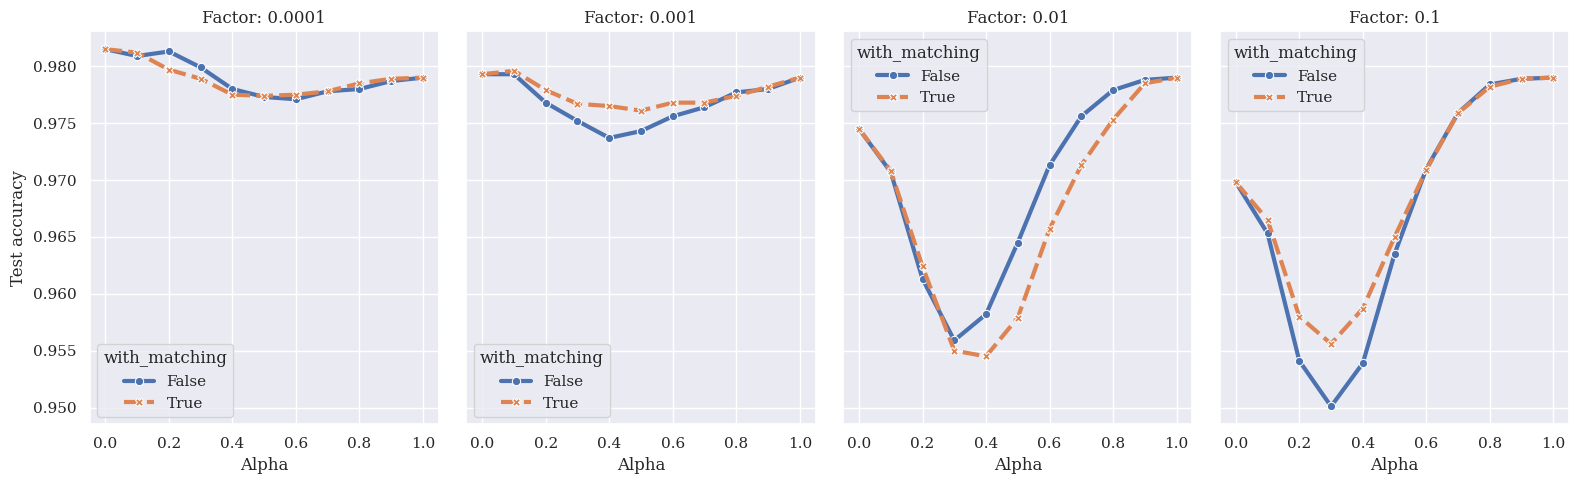

In [241]:
df = pd.DataFrame(rows)
df.sort_values(by=['factor', 'alpha'], inplace=True)
from pyparsing import line
from utils import prepare_sns
prepare_sns()
num_factors = len(df['factor'].unique())
fig, axs = plt.subplots(1, num_factors, figsize=(16, 5), sharey=True)

for i, factor in enumerate(df['factor'].unique()):
    sns.lineplot(data=df[df['factor'] == factor], x='alpha', y='test_acc', 
                 hue='with_matching', ax=axs[i], 
                 linewidth=3, style='with_matching', markers=True,)
    axs[i].set_title(f"Factor: {factor}")
    axs[i].set_xlabel("Alpha")
    axs[i].set_ylabel("Test accuracy")
plt.tight_layout()


显然，在模型差异不大的情况下（0.0001， 0.001）模型直接naive average 效果也不差。
但是在随着正则项factor的增大，naive average的效果也在逐渐变差 （0.01， 0.1）
但是permutation matching 并不是所有时候都有用，比如在factor=0.01的时候，甚至matching之后还差于没有match。
但是总的来说在相同的initialization的情况下，模型聚合起来的的效果都是不错的（0.950~0.98）
比不同的initialization好不少



---

如果non-iid 会怎么影响aggregation的结果呢？

In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [16]:
trainset, testset = prepare_dataset("MNIST", "MLP")
subset = torch.utils.data.Subset(trainset, range(500))
labels = np.array([label for _, label in subset])
prepare_sns()

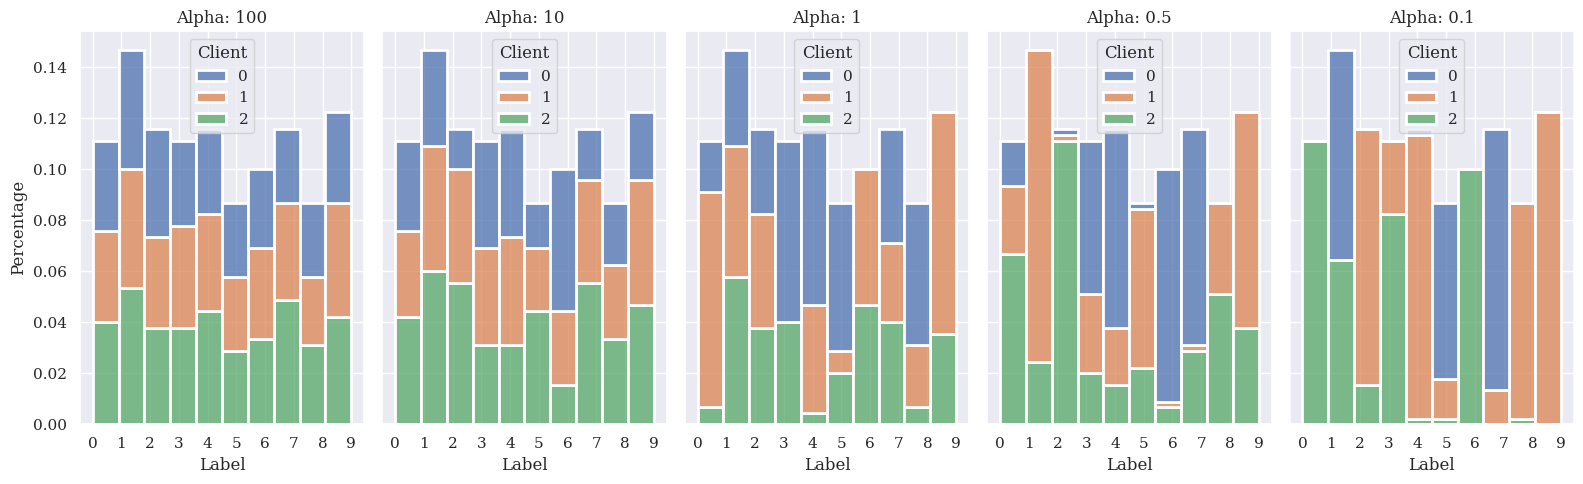

In [56]:
# Assuming 'testset' is your PyTorch test dataset
# Replace this with the actual code to obtain 'labels' from your dataset
from matplotlib.pyplot import xscale


alphas = [100, 10, 1, 0.5, 0.1]
num_classes = 10
fig, axs = plt.subplots(1, len(alphas), figsize=(16, 5), sharey=True)
for alpha_idx, alpha in enumerate(alphas):
    idx_slices = dirichlet_distribution_noniid_slice(labels, 3, alpha)
    # Prepare data for histogram
    data = {'Client': [], 'Label': []}
    for i, idx_slice in enumerate(idx_slices):
        client_id = [i] * len(idx_slice)
        data['Client'].extend(client_id)
        data['Label'].extend(labels[idx_slice])
    data = pd.DataFrame(data)
    data['Client'] = data['Client'].astype('category')
    sns.histplot(data, x='Label', 
                hue='Client', 
                ax=axs[alpha_idx], 
                multiple='stack',
                stat='density',
                fill=True,
                linewidth=2,)
    axs[alpha_idx].set_title(f"Alpha: {alpha}")
    axs[alpha_idx].set_xlabel("Label")
    axs[alpha_idx].set_ylabel("Percentage")
    axs[alpha_idx].set_xticks(range(num_classes))
    axs[alpha_idx].set_xticklabels(range(num_classes))
plt.tight_layout()
plt.show()

非常显然，alpha 越高数据分布越non-iid （这里的non-iid主要还是指的class label 的 non-iid）

现在我们对不同的alpha 分别训练模型

In [35]:
from typing import List
from fastapi.datastructures import Default
from split import dirichlet_distribution_noniid_slice
from parallel import SpecGenerator, TaskSpec
import numpy as np
from pytorch_lightning import seed_everything
from utils import prepare_dataset, build_mlp_model
import torchmetrics
import logger

def non_iid_training_experiment(idxs: List[List[int]] or List[np.ndarray],
                                alpha: float):
    seed_everything(42)
    # same initialization
    trainset, _ = prepare_dataset("MNIST", "MLP")
    model = build_mlp_model()
    metrics = torchmetrics.MetricCollection(
        [torchmetrics.Accuracy(task='multiclass', num_classes=10),]
    )
    loggers = logger.LoggerCollection(
        [
            logger.DummyPrintLogger(),
        ]
    )
    criterion = torch.nn.CrossEntropyLoss()
    from trainer import DefaultTrainer
    trainer = DefaultTrainer(
                model=model,
                optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
                criterion=criterion,
                metrics=metrics,
                loggers=loggers,
                device="cuda",
                need_saving=True,
                saving_on='last',
                saving_dir=f"different_niid_alphas/checkpoints/alpha_{alpha}", 
    )
    results = []
    for i, idx in enumerate(idxs):
        subset = torch.utils.data.Subset(trainset, idx)
        print(f"Client {i} has {len(subset)} samples")
        train_loader = torch.utils.data.DataLoader(subset, 
                                               batch_size=256, 
                                               shuffle=True)
        trainer.saving_name = f"alpha_{alpha}_client_{i}"
        csv_logger = logger.CSVLogger(name=f"alpha_{alpha}_client_{i}",
                                      saving_dir=f"different_niid_alphas/logs/",)
        trainer.loggers = logger.LoggerCollection([csv_logger,])
        trainer.step = 0 
        result = trainer.fit(train_loader, epochs=30)
        result['id'] = i
        results.append(result)
    del model
    del trainer
    torch.cuda.empty_cache()
    return results


class NonIIDExperimentsSepcGenerator(SpecGenerator):
    def __init__(self, alphas: List[float]):
        self.alphas = alphas
        trainset, _ = prepare_dataset("MNIST", "MLP")
        if hasattr(trainset, 'targets'):
            print('Using cached labels')
            self.labels = np.array(trainset.targets)
        else:
            print('Iterating over dataset to get labels')
            print('This may take a while...')
            self.labels = np.array([label for _, label in trainset])
        
    def __iter__(self):
        for alpha in self.alphas:
            idxs = dirichlet_distribution_noniid_slice(self.labels, 2, alpha)
            yield TaskSpec(
                id=f"alpha_{alpha}",
                args=(idxs, alpha,),
                kwargs={},
            )
    def __next__(self) -> TaskSpec:
        return next(self.__iter__())

In [36]:
executor = ParallelExecutor(gpu_fraction=0.3)
task_spec_generator = NonIIDExperimentsSepcGenerator(alphas=[100, 10, 1, 0.5, 0.1])
executor.run(func=non_iid_training_experiment, 
             spec_generator=task_spec_generator)

Using cached labels


(non_iid_training_experiment pid=141003) Global seed set to 42


(non_iid_training_experiment pid=141003) Client 0 has 29126 samples
(non_iid_training_experiment pid=141003) File different_niid_alphas/logs/alpha_10_client_0.csv already exists. It will be overwritten.


Epoch 0 - loss: 1.7798:   9%|▉         | 11/117 [00:01<00:15,  6.80it/s]
(non_iid_training_experiment pid=141006) Global seed set to 42 [repeated 4x across cluster]
Epoch 27 - loss: 0.0397:  86%|████████▋ | 101/117 [00:14<00:02,  6.86it/s] [repeated 147x across cluster]


(non_iid_training_experiment pid=141006) Training Ends
(non_iid_training_experiment pid=141006) Client 0 has 27600 samples [repeated 4x across cluster]
(non_iid_training_experiment pid=141006) File different_niid_alphas/logs/alpha_0.1_client_0.csv already exists. It will be overwritten. [repeated 4x across cluster]
(non_iid_training_experiment pid=141006) Training Results: {'MulticlassAccuracy': tensor(0.9939, device='cuda:0'), 'loss': tensor(0.0172, device='cuda:0', grad_fn=<DivBackward0>)}


Epoch 29 - loss: 0.0140: 100%|██████████| 114/114 [00:16<00:00,  7.07it/s]


(non_iid_training_experiment pid=141003) Training Ends
(non_iid_training_experiment pid=141006) Client 1 has 32400 samples
(non_iid_training_experiment pid=141006) File different_niid_alphas/logs/alpha_0.1_client_1.csv already exists. It will be overwritten.
(non_iid_training_experiment pid=141003) Training Results: {'MulticlassAccuracy': tensor(0.9893, device='cuda:0'), 'loss': tensor(0.0321, device='cuda:0', grad_fn=<DivBackward0>)}
(non_iid_training_experiment pid=141003) Client 1 has 30874 samples
(non_iid_training_experiment pid=141003) File different_niid_alphas/logs/alpha_10_client_1.csv already exists. It will be overwritten.


Epoch 26 - loss: 0.0032: 100%|██████████| 129/129 [00:18<00:00,  6.89it/s]


(non_iid_training_experiment pid=141002) Training Ends
(non_iid_training_experiment pid=141002) Training Results: {'MulticlassAccuracy': tensor(0.9899, device='cuda:0'), 'loss': tensor(0.0315, device='cuda:0', grad_fn=<DivBackward0>)}
(non_iid_training_experiment pid=141002) Client 1 has 30181 samples
(non_iid_training_experiment pid=141002) File different_niid_alphas/logs/alpha_100_client_1.csv already exists. It will be overwritten.


Epoch 3 - loss: 0.1050:  33%|███▎      | 39/118 [00:05<00:11,  7.08it/s]


(non_iid_training_experiment pid=141005) Training Ends
(non_iid_training_experiment pid=141005) Training Results: {'MulticlassAccuracy': tensor(0.9950, device='cuda:0'), 'loss': tensor(0.0147, device='cuda:0', grad_fn=<DivBackward0>)}
(non_iid_training_experiment pid=141005) Client 1 has 27184 samples
(non_iid_training_experiment pid=141005) File different_niid_alphas/logs/alpha_0.5_client_1.csv already exists. It will be overwritten.


Epoch 6 - loss: 0.0235:   6%|▋         | 8/127 [00:01<00:17,  6.72it/s]


(non_iid_training_experiment pid=141004) Training Ends
(non_iid_training_experiment pid=141004) Training Results: {'MulticlassAccuracy': tensor(0.9889, device='cuda:0'), 'loss': tensor(0.0337, device='cuda:0', grad_fn=<DivBackward0>)}
(non_iid_training_experiment pid=141004) Client 1 has 26149 samples
(non_iid_training_experiment pid=141004) File different_niid_alphas/logs/alpha_1_client_1.csv already exists. It will be overwritten.


Epoch 29 - loss: 0.0112:  92%|█████████▏| 108/118 [00:16<00:01,  6.89it/s]


(non_iid_training_experiment pid=141003) Training Results: {'MulticlassAccuracy': tensor(0.9952, device='cuda:0'), 'loss': tensor(0.0148, device='cuda:0', grad_fn=<DivBackward0>)}
(non_iid_training_experiment pid=141003) Training Ends


Epoch 29 - loss: 0.0200:  46%|████▌     | 49/107 [00:07<00:08,  6.84it/s]


(non_iid_training_experiment pid=141002) Training Ends


Epoch 29 - loss: 0.0177:  94%|█████████▎| 119/127 [00:16<00:01,  6.74it/s] [repeated 3x across cluster]


(non_iid_training_experiment pid=141006) Training Results: {'MulticlassAccuracy': tensor(0.9923, device='cuda:0'), 'loss': tensor(0.0228, device='cuda:0', grad_fn=<DivBackward0>)} [repeated 2x across cluster]
(non_iid_training_experiment pid=141006) Training Ends
(non_iid_training_experiment pid=141005) Training Ends


Epoch 29 - loss: 0.0065:  90%|█████████ | 93/103 [00:13<00:01,  6.85it/s] [repeated 69x across cluster]


Finished running tasks


[TaskResults(id='alpha_100', results=[{'step': 3510, 'train_step_loss': 0.025595361366868, 'train_step_MulticlassAccuracy': 0.98828125, 'train_epoch_loss': 0.0315452776849269, 'train_epoch_MulticlassAccuracy': 0.9899057745933532, 'id': 0}, {'step': 3540, 'train_step_loss': 0.0355446077883243, 'train_step_MulticlassAccuracy': 0.9921875, 'train_epoch_loss': 0.0177564527839422, 'train_epoch_MulticlassAccuracy': 0.9937046766281128, 'id': 1}]),
 TaskResults(id='alpha_10', results=[{'step': 3420, 'train_step_MulticlassAccuracy': 0.98828125, 'train_step_loss': 0.0654312744736671, 'train_epoch_loss': 0.0320594273507595, 'train_epoch_MulticlassAccuracy': 0.9893222451210022, 'id': 0}, {'step': 3630, 'train_step_MulticlassAccuracy': 0.99609375, 'train_step_loss': 0.0136347217485308, 'train_epoch_loss': 0.0148251745849847, 'train_epoch_MulticlassAccuracy': 0.995238721370697, 'id': 1}]),
 TaskResults(id='alpha_1', results=[{'step': 3990, 'train_step_loss': 0.0230072978883981, 'train_step_Multiclass

(non_iid_training_experiment pid=141004) Training Ends
(non_iid_training_experiment pid=141004) Training Results: {'MulticlassAccuracy': tensor(0.9961, device='cuda:0'), 'loss': tensor(0.0116, device='cuda:0', grad_fn=<DivBackward0>)}


Epoch 29 - loss: 0.0718: 100%|██████████| 103/103 [00:15<00:00,  6.80it/s]


看一下各自在测试集的表现

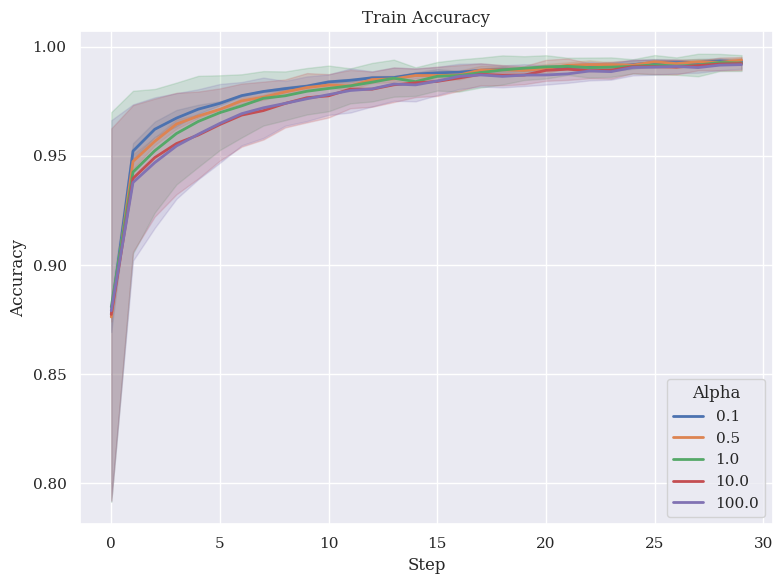

In [65]:
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from utils import prepare_sns

csv_paths = os.listdir("different_niid_alphas/logs")
df = pd.DataFrame()

prepare_sns()

for csv_path in csv_paths:
    csv_file = os.path.join("different_niid_alphas/logs", csv_path)
    alpha = float(csv_path.split("_")[1])
    client = int(csv_path.split("_")[3].rstrip(".csv"))
    temp_df = pd.read_csv(csv_file)
    temp_df['step'] = temp_df['step']
    temp_df['accuracy'] = temp_df['train_epoch_MulticlassAccuracy']
    temp_df['alpha'] = alpha
    temp_df['client'] = client
    temp_df = temp_df[['step', 'accuracy', 'alpha', 'client']]
    temp_df.dropna(inplace=True)
    temp_df['epoch'] = temp_df.reset_index().index
    df = pd.concat([df, temp_df], axis=0, ignore_index=True)

df = df.sort_values(by=['alpha', 'step'], ascending=False)
df['alpha'] = df['alpha'].astype('category')
df['client'] = df['client'].astype('category')

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.lineplot(data=df, x='epoch', y='accuracy',
             ax=ax, hue='alpha', linewidth=2, 
             dashes=False, err_style='band', )

ax.set_title("Train Accuracy")
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")

# Change the legend title to alpha
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Alpha', loc='lower right')

plt.tight_layout()


显然基本上所有的client都会在训练集上达到很高的精度。但是奇怪的是为什么alpha更高的时候，更iid的情况下training curve 更不稳定？（阴影部分更大？）

可能需要一个解释。anyway，我们看一下test集合的性能

In [2]:
from typing import Callable, Literal
from utils import prepare_dataset, build_mlp_model
from lightning import seed_everything
from trainer import DefaultTrainer
import torchmetrics
import logger
import torch
def evaluate_model(
    model_state_dict: dict,
    model_builder: Callable,
    device: Literal['cpu', 'cuda']) -> dict:
    model = model_builder()
    model.load_state_dict(model_state_dict)
    seed_everything(42)
    _, testset = prepare_dataset("MNIST", "MLP")
    trainer = DefaultTrainer(
        model=model,
        optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
        criterion=torch.nn.CrossEntropyLoss(),
        metrics=torchmetrics.MetricCollection(
            [torchmetrics.Accuracy(task='multiclass', num_classes=10),]
        ),
        loggers=logger.LoggerCollection(
            [logger.DummyPrintLogger()]
        ),
        device="cuda",
        need_saving=False)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1000)
    results = trainer.evaluate(testloader)
    return results

In [4]:
specs = []
from parallel import TaskSpec, ParallelExecutor
import torch
from utils import build_mlp_model, prepare_dataset
import os
from trainer import DefaultTrainer

for dir in os.listdir("different_niid_alphas/checkpoints"):
    alpha = float(dir.split("_")[1])
    ckpt_dir = os.path.join("different_niid_alphas/checkpoints", dir)
    for ckpt in os.listdir(ckpt_dir):
        ckpt_path = os.path.join(ckpt_dir, ckpt)
        # client_id = int(ckpt.split("_")[3].rstrip(".pth"))
        client_id = int(ckpt.split("_")[3])
        ckpt = torch.load(ckpt_path)
        model_state_dict = ckpt['model_state_dict']
        spec = TaskSpec(
            id=f"alpha_{alpha}_client_{client_id}",
            args=(model_state_dict, 
                  build_mlp_model, 'cuda'),
            kwargs={},
        )
        specs.append(spec)
print(len(specs))

10


In [5]:
len(specs)

10

In [6]:
executor = ParallelExecutor(gpu_fraction=0.3)
results = executor.run(func=evaluate_model, task_specs=specs)

2024-01-11 17:55:20,889	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(evaluate_model pid=466382) Global seed set to 42


(evaluate_model pid=466382) Evaluation Starts


 50%|█████     | 5/10 [00:01<00:01,  3.50it/s]


(evaluate_model pid=466382) Step 0: {'test_epoch_MulticlassAccuracy': 0.9703999757766724, 'test_epoch_loss': 0.10125306993722916}
(evaluate_model pid=466382) Evaluation Ends
(evaluate_model pid=466382) Test Results: {'MulticlassAccuracy': 0.9703999757766724, 'loss': 0.10125306993722916}


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]
(evaluate_model pid=466389) Global seed set to 42 [repeated 9x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


(evaluate_model pid=466390) Evaluation Starts [repeated 9x across cluster]


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 9x across cluster]


Finished running tasks


(evaluate_model pid=466390) Step 0: {'test_epoch_MulticlassAccuracy': 0.9527000188827515, 'test_epoch_loss': 0.19665631651878357}
(evaluate_model pid=466390) Evaluation Ends
(evaluate_model pid=466390) Test Results: {'MulticlassAccuracy': 0.9527000188827515, 'loss': 0.19665631651878357}


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


In [13]:
results

[TaskResults(id='alpha_10.0_client_1', results={'MulticlassAccuracy': 0.9775999784469604, 'loss': 0.08247838914394379}),
 TaskResults(id='alpha_10.0_client_0', results={'MulticlassAccuracy': 0.9703999757766724, 'loss': 0.10125306993722916}),
 TaskResults(id='alpha_100.0_client_0', results={'MulticlassAccuracy': 0.9693999886512756, 'loss': 0.11059897392988205}),
 TaskResults(id='alpha_100.0_client_1', results={'MulticlassAccuracy': 0.9764999747276306, 'loss': 0.09249741584062576}),
 TaskResults(id='alpha_1.0_client_1', results={'MulticlassAccuracy': 0.9546999931335449, 'loss': 0.20212297141551971}),
 TaskResults(id='alpha_1.0_client_0', results={'MulticlassAccuracy': 0.9659000039100647, 'loss': 0.13009507954120636}),
 TaskResults(id='alpha_0.1_client_1', results={'MulticlassAccuracy': 0.7660999894142151, 'loss': 4.46243953704834}),
 TaskResults(id='alpha_0.1_client_0', results={'MulticlassAccuracy': 0.6413999795913696, 'loss': 6.8624467849731445}),
 TaskResults(id='alpha_0.5_client_0', 

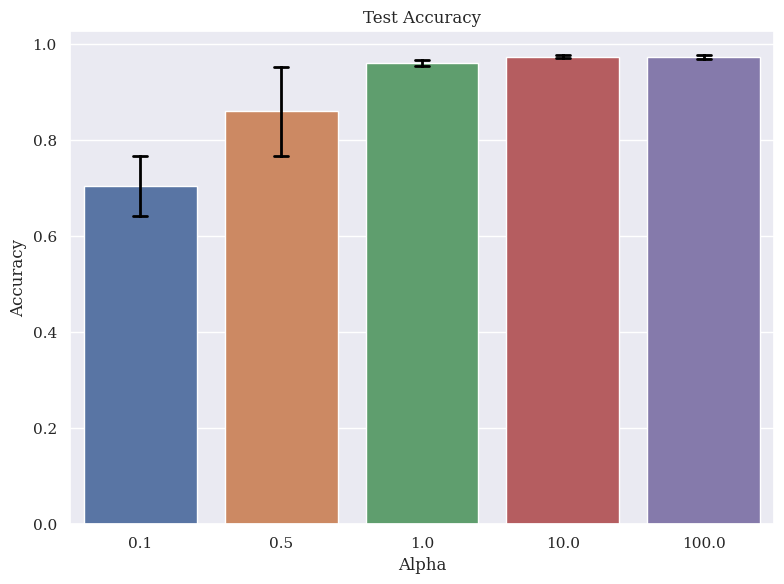

In [24]:
from pandas import DataFrame
from parallel import TaskResults
from typing import List
import pandas as pd
def parse_results(results:List[TaskResults]) -> pd.DataFrame:
    rows = []
    for result in results:
        row = {
            'client': result.id.split("_")[3],
            'alpha': result.id.split("_")[1],
            'test_acc': result.results['MulticlassAccuracy'],
            'test_loss': result.results['loss'],
        }
        rows.append(row)
    return DataFrame(rows)
df = parse_results(results)
import seaborn as sns
from utils import prepare_sns
import matplotlib.pyplot as plt
prepare_sns()
df['alpha'] = df['alpha'].astype('category')
df['client'] = df['client'].astype('category')
df = df.sort_values(by=['alpha', 'client'])
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.barplot(data=df, x='alpha', y='test_acc', ax=ax, hue="alpha", 
            capsize=0.1, err_kws={"color": "black", "linewidth": 2})
ax.set_title("Test Accuracy")
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
plt.tight_layout()

很显然，更大的heterogeneity 模型performance的方差也越大

permutation的实验

In [30]:
def permutation_experiments(
    model_state_dict_1: dict,
    model_state_dict_2: dict,
    model_builder: Callable,
    trainer_builder: Callable,
    testloader: torch.utils.data.DataLoader,
    valloader: torch.utils.data.DataLoader,
    device: Literal['cpu', 'cuda'],
    saving_dir:str) -> dict:
    import os
    if not os.path.exists(saving_dir):
        os.makedirs(saving_dir)
    model = model_builder()
    import numpy as np
    alphas = np.linspace(0.0, 1.0, 11)
    results_rows = []
    from interpolate import interpolate_weights
    from permute import match_and_permute
    for alpha in alphas:
        interpolated_state_dict = interpolate_weights(model_state_dict_1,
                                                      model_state_dict_2,
                                                      alpha)
        torch.save(
            interpolated_state_dict, 
            os.path.join(saving_dir, f"interpolated_{alpha}.pth")
            )
        model.load_state_dict(interpolated_state_dict)
        # test the interpolted state dict is correct
        test_results = trainer_builder(model).evaluate(testloader)
        results_rows.append({
            "alpha": alpha,
            "test_acc": test_results['MulticlassAccuracy'],
            "test_loss": test_results['loss'],
            "with_matching": False, 
        })
        print("Starts matching and permuting")
        permuted_state_dict_2 = match_and_permute(model_builder=model_builder,
                                                  state_dict_1=model_state_dict_1,
                                                  state_dict_2=model_state_dict_2,
                                                  val_loader=valloader,
                                                  device=device)
        permuted_interpolated_state_dict = interpolate_weights(model_state_dict_1,
                                                               permuted_state_dict_2,
                                                               alpha)
        torch.save(
            permuted_interpolated_state_dict,
            os.path.join(saving_dir, f"permuted_interpolated_{alpha}.pth")
            )
        model.load_state_dict(permuted_interpolated_state_dict)
        test_results = trainer_builder(model).evaluate(testloader)
        results_rows.append({
            "alpha": alpha,
            "test_acc": test_results['MulticlassAccuracy'],
            "test_loss": test_results['loss'],
            "with_matching": True, 
        })
    return results_rows

In [31]:
def trainer_builder(model):
    return DefaultTrainer(
        model=model,
        optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
        criterion=torch.nn.CrossEntropyLoss(),
        metrics=torchmetrics.MetricCollection(
            [torchmetrics.Accuracy(task='multiclass', num_classes=10),]
        ),
        loggers=logger.LoggerCollection(
            [logger.DummyPrintLogger()]
        ),
        device="cuda",
        need_saving=False,
    )

In [32]:
from torch import seed
from parallel import TaskSpec, ParallelExecutor, SpecGenerator
from itertools import groupby
permuation_specs = []
seed_everything(42)
trainset, testset = prepare_dataset("MNIST", "MLP")
valset = torch.utils.data.Subset(testset, range(100))
valloader = torch.utils.data.DataLoader(valset, batch_size=1000)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000)
for key, group in groupby(specs, key=lambda x: x.id.split("_")[1]):
    state_dicts_list = [item.args[0] for item in group]
    assert len(state_dicts_list) == 2
    model_state_dict_1, model_state_dict_2 = state_dicts_list  
    model_builder = build_mlp_model
    trainer_builder = trainer_builder
    saving_dir = f"different_niid_alphas/permuted_interpolated/{key}"
    spec = TaskSpec(
        id=key,
        args=(model_state_dict_1, 
              model_state_dict_2,
              model_builder, 
              trainer_builder,
              testloader,
              valloader,
              'cuda',
              saving_dir),
        kwargs={},
    )
    permuation_specs.append(spec)

Global seed set to 42


In [41]:
executor = ParallelExecutor(gpu_fraction=0.3)
results = executor.run(func=permutation_experiments, 
             task_specs=permuation_specs)

(permutation_experiments pid=519605) Evaluation Starts


 20%|██        | 2/10 [00:00<00:02,  2.88it/s]


(permutation_experiments pid=519605) Step 0: {'test_epoch_MulticlassAccuracy': 0.6413999795913696, 'test_epoch_loss': 6.8624467849731445}
(permutation_experiments pid=519605) Evaluation Ends
(permutation_experiments pid=519605) Test Results: {'MulticlassAccuracy': 0.6413999795913696, 'loss': 6.8624467849731445}
(permutation_experiments pid=519605) Starts matching and permuting


  0%|          | 0/10 [00:00<?, ?it/s] [repeated 9x across cluster]


(permutation_experiments pid=519605) Evaluation Starts [repeated 10x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.00it/s] [repeated 9x across cluster]


(permutation_experiments pid=519605) Step 0: {'test_epoch_MulticlassAccuracy': 0.6656000018119812, 'test_epoch_loss': 3.1019387245178223} [repeated 10x across cluster]
(permutation_experiments pid=519605) Evaluation Ends [repeated 10x across cluster]
(permutation_experiments pid=519605) Test Results: {'MulticlassAccuracy': 0.6656000018119812, 'loss': 3.1019387245178223} [repeated 10x across cluster]
(permutation_experiments pid=519605) Starts matching and permuting [repeated 5x across cluster]


 80%|████████  | 8/10 [00:01<00:00,  3.93it/s] [repeated 86x across cluster]


(permutation_experiments pid=519605) Evaluation Starts [repeated 10x across cluster]


100%|██████████| 10/10 [00:02<00:00,  3.91it/s] [repeated 10x across cluster]


(permutation_experiments pid=519605) Step 0: {'test_epoch_MulticlassAccuracy': 0.5978000164031982, 'test_epoch_loss': 1.6824384927749634} [repeated 10x across cluster]
(permutation_experiments pid=519605) Evaluation Ends [repeated 10x across cluster]
(permutation_experiments pid=519605) Test Results: {'MulticlassAccuracy': 0.5978000164031982, 'loss': 1.6824384927749634} [repeated 10x across cluster]
(permutation_experiments pid=519605) Starts matching and permuting [repeated 5x across cluster]


 70%|███████   | 7/10 [00:01<00:00,  4.09it/s] [repeated 88x across cluster]


(permutation_experiments pid=519606) Evaluation Starts [repeated 9x across cluster]


100%|██████████| 10/10 [00:02<00:00,  3.96it/s] [repeated 10x across cluster]


(permutation_experiments pid=519605) Step 0: {'test_epoch_MulticlassAccuracy': 0.5677000284194946, 'test_epoch_loss': 1.3767846822738647} [repeated 10x across cluster]
(permutation_experiments pid=519605) Evaluation Ends [repeated 10x across cluster]
(permutation_experiments pid=519605) Test Results: {'MulticlassAccuracy': 0.5677000284194946, 'loss': 1.3767846822738647} [repeated 10x across cluster]
(permutation_experiments pid=519605) Starts matching and permuting [repeated 5x across cluster]


 50%|█████     | 5/10 [00:01<00:01,  4.10it/s] [repeated 87x across cluster]


(permutation_experiments pid=519605) Evaluation Starts [repeated 11x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.11it/s] [repeated 10x across cluster]


(permutation_experiments pid=519605) Step 0: {'test_epoch_MulticlassAccuracy': 0.585099995136261, 'test_epoch_loss': 1.3866099119186401} [repeated 10x across cluster]
(permutation_experiments pid=519605) Evaluation Ends [repeated 10x across cluster]
(permutation_experiments pid=519605) Test Results: {'MulticlassAccuracy': 0.585099995136261, 'loss': 1.3866099119186401} [repeated 10x across cluster]
(permutation_experiments pid=519605) Starts matching and permuting [repeated 5x across cluster]


 70%|███████   | 7/10 [00:01<00:00,  4.14it/s] [repeated 89x across cluster]


(permutation_experiments pid=519605) Evaluation Starts [repeated 10x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.08it/s] [repeated 10x across cluster]


(permutation_experiments pid=519605) Step 0: {'test_epoch_MulticlassAccuracy': 0.6542999744415283, 'test_epoch_loss': 1.5474309921264648} [repeated 10x across cluster]
(permutation_experiments pid=519605) Evaluation Ends [repeated 10x across cluster]
(permutation_experiments pid=519605) Test Results: {'MulticlassAccuracy': 0.6542999744415283, 'loss': 1.5474309921264648} [repeated 10x across cluster]
(permutation_experiments pid=519605) Starts matching and permuting [repeated 5x across cluster]


 50%|█████     | 5/10 [00:01<00:01,  3.92it/s] [repeated 87x across cluster]


(permutation_experiments pid=519605) Evaluation Starts [repeated 10x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.09it/s] [repeated 10x across cluster]


(permutation_experiments pid=519605) Step 0: {'test_epoch_MulticlassAccuracy': 0.7032999992370605, 'test_epoch_loss': 1.84274160861969} [repeated 10x across cluster]
(permutation_experiments pid=519605) Evaluation Ends [repeated 10x across cluster]
(permutation_experiments pid=519605) Test Results: {'MulticlassAccuracy': 0.7032999992370605, 'loss': 1.84274160861969} [repeated 10x across cluster]
(permutation_experiments pid=519605) Starts matching and permuting [repeated 5x across cluster]


 50%|█████     | 5/10 [00:01<00:01,  3.96it/s] [repeated 91x across cluster]


(permutation_experiments pid=519604) Evaluation Starts [repeated 10x across cluster]


100%|██████████| 10/10 [00:02<00:00,  3.50it/s] [repeated 10x across cluster]


(permutation_experiments pid=519605) Step 0: {'test_epoch_MulticlassAccuracy': 0.7332000136375427, 'test_epoch_loss': 2.2735848426818848} [repeated 10x across cluster]
(permutation_experiments pid=519605) Evaluation Ends [repeated 10x across cluster]
(permutation_experiments pid=519605) Test Results: {'MulticlassAccuracy': 0.7332000136375427, 'loss': 2.2735848426818848} [repeated 10x across cluster]
(permutation_experiments pid=519605) Starts matching and permuting [repeated 5x across cluster]


 60%|██████    | 6/10 [00:01<00:00,  4.04it/s] [repeated 82x across cluster]


(permutation_experiments pid=519604) Evaluation Starts [repeated 10x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.12it/s] [repeated 9x across cluster]


(permutation_experiments pid=519605) Step 0: {'test_epoch_MulticlassAccuracy': 0.7530999779701233, 'test_epoch_loss': 2.846959114074707} [repeated 10x across cluster]
(permutation_experiments pid=519605) Evaluation Ends [repeated 10x across cluster]
(permutation_experiments pid=519605) Test Results: {'MulticlassAccuracy': 0.7530999779701233, 'loss': 2.846959114074707} [repeated 10x across cluster]
(permutation_experiments pid=519605) Starts matching and permuting [repeated 5x across cluster]


 40%|████      | 4/10 [00:00<00:01,  4.16it/s] [repeated 87x across cluster]


(permutation_experiments pid=519604) Evaluation Starts [repeated 10x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.16it/s] [repeated 10x across cluster]


(permutation_experiments pid=519604) Step 0: {'test_epoch_MulticlassAccuracy': 0.9603999853134155, 'test_epoch_loss': 0.1684298813343048} [repeated 10x across cluster]
(permutation_experiments pid=519604) Evaluation Ends [repeated 10x across cluster]
(permutation_experiments pid=519604) Test Results: {'MulticlassAccuracy': 0.9603999853134155, 'loss': 0.1684298813343048} [repeated 10x across cluster]
(permutation_experiments pid=519604) Starts matching and permuting [repeated 5x across cluster]


 50%|█████     | 5/10 [00:01<00:01,  3.88it/s] [repeated 93x across cluster]


(permutation_experiments pid=519603) Evaluation Starts [repeated 12x across cluster]


100%|██████████| 10/10 [00:02<00:00,  3.98it/s] [repeated 10x across cluster]


(permutation_experiments pid=519604) Step 0: {'test_epoch_MulticlassAccuracy': 0.9546999931335449, 'test_epoch_loss': 0.20212297141551971} [repeated 11x across cluster]
(permutation_experiments pid=519604) Evaluation Ends [repeated 11x across cluster]
(permutation_experiments pid=519604) Test Results: {'MulticlassAccuracy': 0.9546999931335449, 'loss': 0.20212297141551971} [repeated 11x across cluster]
(permutation_experiments pid=519604) Starts matching and permuting [repeated 6x across cluster]


 50%|█████     | 5/10 [00:01<00:01,  4.10it/s] [repeated 91x across cluster]


(permutation_experiments pid=519602) Evaluation Starts [repeated 7x across cluster]


100%|██████████| 10/10 [00:02<00:00,  4.04it/s] [repeated 10x across cluster]


Finished running tasks


In [42]:
records = []
for result in results:
    alpha = result.id
    for result in result.results:
        row = {'niid_factor': alpha}
        row.update(result)
        records.append(row)
df = pd.DataFrame(records)
df.head()

,niid_factor,alpha,test_acc,test_loss,with_matching
0,10.0,0.0,0.9704,0.101253,False
1,10.0,0.0,0.9704,0.101253,True
2,10.0,0.1,0.9738,0.090217,False
3,10.0,0.1,0.9736,0.091204,True
4,10.0,0.2,0.9764,0.082294,False


<Axes: xlabel='alpha', ylabel='test_acc'>

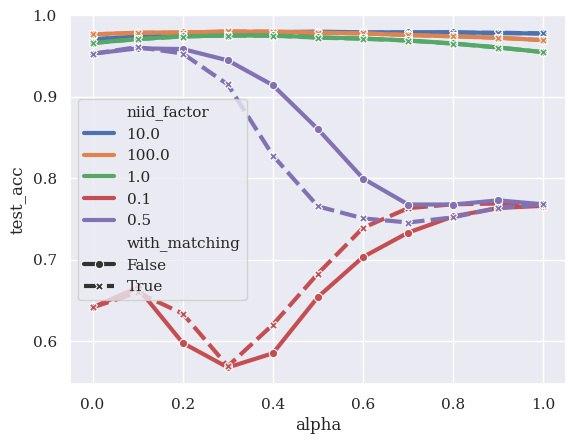

In [44]:
sns.lineplot(data=df, x='alpha', y='test_acc',
                hue='niid_factor', linewidth=3, style='with_matching', markers=True)

---


可视化一下loss landscape?